In [1]:
import numpy as np

# a naive implementation of computing convolutions in one dimension
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([
            zero_pad, x_padded, zero_pad
        ])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d Implementation:', conv1d(x, w, p=2, s=1))
print('NumPy Results:', np.convolve(x, w, mode='same'))

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
NumPy Results: [ 5 14 16 26 24 34 19 22]


In [2]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0], p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0])/s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1]) + 1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return np.array(res)

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation:\n', conv2d(X, W, p=(1, 1), s=(1, 1)))
print('SciPy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


In [3]:
import torch
from torchvision.io import read_image
img = read_image('../data/cat_dog_images/cat-02.jpg')
print('Image shape:', img.shape)
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print(img[:, 100:102, 100:102])

Image shape: torch.Size([3, 900, 1200])
Number of channels: 3
Image data type: torch.uint8
tensor([[[55, 39],
         [58, 37]],

        [[43, 28],
         [46, 26]],

        [[31, 22],
         [34, 20]]], dtype=torch.uint8)


In [4]:
from torch import nn

loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()]
)
loss_with_penalty = loss + l2_penalty
linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

In [5]:
# Binary Cross-entropy
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711


In [6]:
# Categorical Cross-entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(f'CCE (w Probas): {cce_loss_fn(torch.log(probas), target):.4f}')
print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')

CCE (w Probas): 0.5996
CCE (w Logits): 0.5996


In [7]:
import torchvision
from torchvision import transforms
image_path = '../data/'
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)

In [8]:
from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_datset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [9]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_datset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [10]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32, kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64, kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [11]:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [12]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [13]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train(mode, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

            print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [17]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9496 val_accuracy: 0.9792
Epoch 2 accuracy: 0.9848 val_accuracy: 0.9862
Epoch 3 accuracy: 0.9891 val_accuracy: 0.9875
Epoch 4 accuracy: 0.9922 val_accuracy: 0.9898
Epoch 5 accuracy: 0.9934 val_accuracy: 0.9878
Epoch 6 accuracy: 0.9940 val_accuracy: 0.9899
Epoch 7 accuracy: 0.9947 val_accuracy: 0.9891
Epoch 8 accuracy: 0.9965 val_accuracy: 0.9904
Epoch 9 accuracy: 0.9969 val_accuracy: 0.9894
Epoch 10 accuracy: 0.9964 val_accuracy: 0.9902
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9908
Epoch 12 accuracy: 0.9978 val_accuracy: 0.9889
Epoch 13 accuracy: 0.9969 val_accuracy: 0.9900
Epoch 14 accuracy: 0.9978 val_accuracy: 0.9873
Epoch 15 accuracy: 0.9977 val_accuracy: 0.9864
Epoch 16 accuracy: 0.9981 val_accuracy: 0.9902
Epoch 17 accuracy: 0.9983 val_accuracy: 0.9915
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9906
Epoch 19 accuracy: 0.9983 val_accuracy: 0.9905
Epoch 20 accuracy: 0.9981 val_accuracy: 0.9909


In [18]:
for i in range(len(hist[2])):
    hist[2][i] = hist[2][i].to(torch.device('cpu'))
    hist[3][i] = hist[3][i].to(torch.device('cpu'))

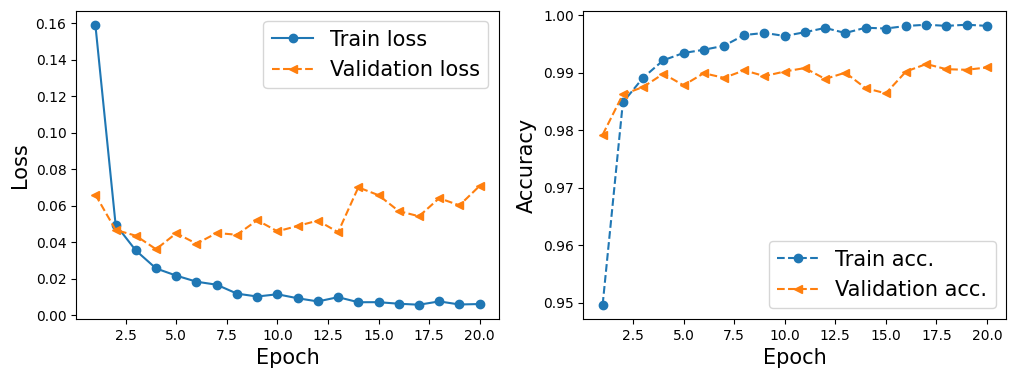

In [19]:
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '--o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [20]:
test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=False)
test_accuracy = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        test_accuracy += is_correct.sum()
    test_accuracy /= len(test_dl.dataset)

print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.9912999868392944


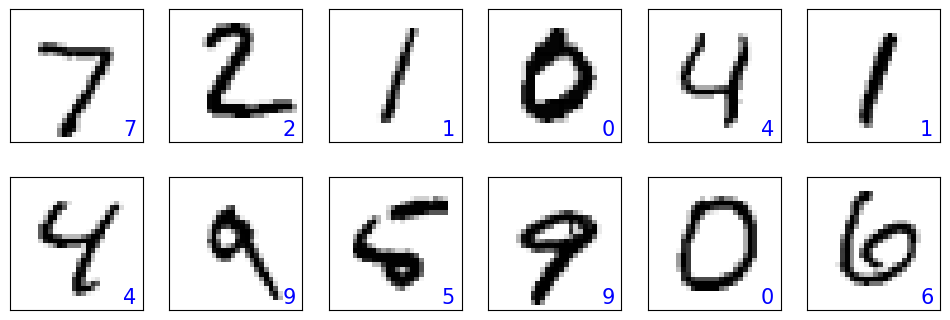

In [21]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1).to(device))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()

In [22]:
model.eval()
misclassified = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_dl):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        is_correct = (torch.argmax(pred, dim=1) == y_batch)
        
        for j in range(y_batch.size(0)):
            if not is_correct[j]:
                misclassified.append(i * batch_size + j)

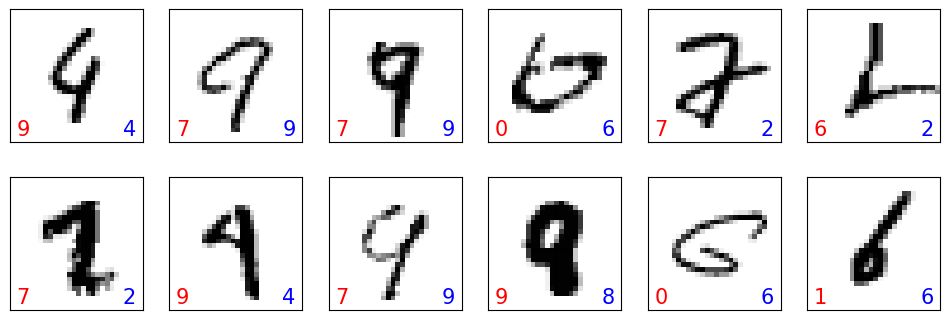

In [27]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[misclassified[i]][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1).to(device))
    y_pred = torch.argmax(pred)
    y_true = mnist_test_dataset[misclassified[i]][1]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.1, 0.1, y_pred.item(), size=15, color='red', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.9, 0.1, y_true, size=15, color='blue', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()